In [2]:
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image


class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + '*')
        img_file = glob(self.imgs_dir + idx + '*')

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)

        return {'image': torch.from_numpy(img), 'mask': torch.from_numpy(mask)}

In [5]:
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from eval import eval_net
from unet import UNet

from torch.utils.tensorboard import SummaryWriter
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split

dir_img = 'data/imgs/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'


def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=0.5):

    dataset = BasicDataset(dir_img, dir_mask, img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images scaling:  {img_scale}
    ''')

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    if net.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1
                if global_step % (len(dataset) // (10 * batch_size)) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)

        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('-e', '--epochs', metavar='E', type=int, default=5,
                        help='Number of epochs', dest='epochs')
    parser.add_argument('-b', '--batch-size', metavar='B', type=int, nargs='?', default=1,
                        help='Batch size', dest='batchsize')
    parser.add_argument('-l', '--learning-rate', metavar='LR', type=float, nargs='?', default=0.1,
                        help='Learning rate', dest='lr')
    parser.add_argument('-f', '--load', dest='load', type=str, default=False,
                        help='Load model from a .pth file')
    parser.add_argument('-s', '--scale', dest='scale', type=float, default=0.5,
                        help='Downscaling factor of the images')
    parser.add_argument('-v', '--validation', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')

    return parser.parse_args()

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
#   - For 1 class and background, use n_classes=1
#   - For 2 classes, use n_classes=1
#   - For N > 2 classes, use n_classes=N
net = UNet(n_channels=3, n_classes=1, bilinear=True)
logging.info(f'Network:\n'
             f'\t{net.n_channels} input channels\n'
             f'\t{net.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')

if args.load:
    net.load_state_dict(
        torch.load(args.load, map_location=device)
    )
    logging.info(f'Model loaded from {args.load}')

net.to(device=device)
# faster convolutions, but more memory
# cudnn.benchmark = True

In [6]:
dir_img = 'data/imgs/'
dir_mask = 'data/masks/'
dir_checkpoint = 'checkpoints/'

In [8]:
epochs=5
batch_size=1
lr=0.001
val_percent=0.1
save_cp=True
img_scale=0.5

In [9]:
dataset = BasicDataset(dir_img, dir_mask, img_scale)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
global_step = 0

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [16]:
%matplotlib inline
import sys
COCOAPI_PATH = '/Users/parkkyuyeol/Desktop/DGIST_intern/cocoapi/PythonAPI'
sys.path.append(COCOAPI_PATH)
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import cv2

In [17]:
dataDir='/Users/parkkyuyeol/Desktop/DGIST_intern/cocodataset'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [18]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [19]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
person vehicle appliance indoor furniture animal sports accessory food kitchen outdoor electronic


In [20]:
cats

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [21]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

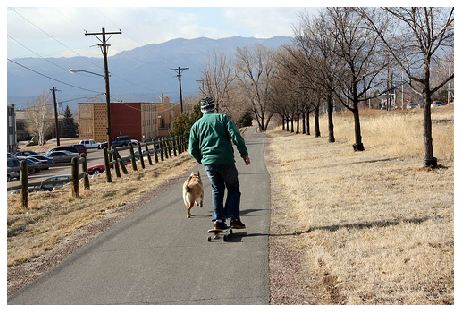

In [22]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

NameError: name 'i' is not defined

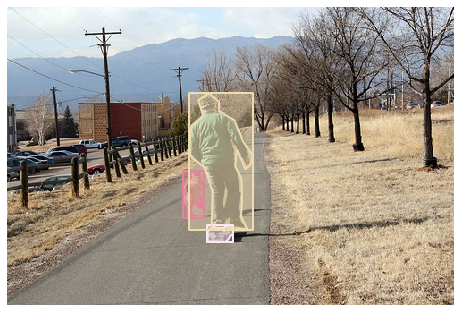

In [23]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=1)


anns2 = coco.dataset['annotations']
anns2[1]['bbox']

# plt.savefig("../savefig_default.png")



green = (0, 255, 0)
info = coco.imgs[anns[i]['image_id']]
img_w = info['width']
img_h = info['height']
print(img_w, img_h)
mask = np.zeros((img_h,img_w,1), np.uint8)

for i in range(len(anns)):
    print(anns[i]['category_id'], anns[i]['bbox'])
    p1, p2 = anns[i]['bbox'][:2], [a-b for a,b in zip(anns[i]['bbox'][:2],anns[i]['bbox'][2:])]
#     p1 = (tuple)(p1); p2 = (tuple)(p2)
    print(p1, p2)
#     p1 = (25, 25); p2 = (100,100)
#     print(p1, p2)
#     mask = cv2.rectangle(mask, p[:2], p[2:], anns[i]['category_id'], 1)
    mask = cv2.rectangle(mask, p1, p2, 255, -1)
#     mask = cv2.rectangle(mask, (25,25), (100,100), 255, -1)

cv2.imwrite("../original1.png", I)
cv2.imwrite("../mask_ex1.png", mask)
    



# img = np.zeros(())

# aa = coco.imgs[anns[1]['image_id']]

# coco.anns['bbox']
# anns['bbox']
# np_anns = coco.loadNumpyAnnotations(annIds)
# np_anns['bbox']

NameError: name 'git' is not defined